# Práctica 5: Tech evolution. Caso POS Tagging

- Obten los embeddings de 100 palabras al azar del modelo RNN visto en clase
  - Pueden ser los embeddings estáticos o los dinámicos del modelo
- Aplica un algoritmo de clusterización a las palabras y plotearlas en 2D
  - Aplica algun color para los diferentes clusters
- Agrega al plot los embeddings de las etiquetas POS
  - Utiliza un marcador que las distinga claramente de las palabras
- Realiza una conclusión sobre los resultados observados

In [2]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import requests
import re
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tqdm.notebook import trange, tqdm

## Corpus

In [3]:
def download_ud_corpus(lang="es"):
    repo, file_name = "UD_Spanish-AnCora", "es_ancora-ud"
    data = {}
    for split in ["train", "dev", "test"]:
        url = f"https://raw.githubusercontent.com/UniversalDependencies/{repo}/refs/heads/master/{file_name}-{split}.conllu"
        data[split] = requests.get(url).text
    return data

corpus_data = download_ud_corpus()

In [4]:
class CoNLLParser:
    def __init__(self):
        self.columns = ["ID", "FORM", "LEMMA", "UPOS", "XPOS", 
                        "FEATS", "HEAD", "DEPREL", "DEPS", "MISC"]

    def parse(self, raw_text):
        sents = raw_text.strip().split("\n\n")
        data = []
        for sent in sents:
            tokens = [line.split("\t") for line in sent.split("\n") if not line.startswith("#")]
            tokens = [dict(zip(self.columns, tok)) for tok in tokens]
            data.append(tokens)
        return data

parser = CoNLLParser()
train_data = parser.parse(corpus_data["train"])

## Extracción de palabras y POS

In [5]:
def extract_words_and_pos(sentences):
    word_seqs, pos_seqs = [], []
    for sent in sentences:
        word_seqs.append([t["FORM"].lower() for t in sent])
        pos_seqs.append([t["UPOS"] for t in sent])
    return word_seqs, pos_seqs

train_words, train_pos = extract_words_and_pos(train_data)

In [6]:
word_vocab = sorted(set(w for s in train_words for w in s))
pos_vocab = sorted(set(p for s in train_pos for p in s))

idx2word = {i+2: w for i, w in enumerate(word_vocab)}
word2idx = {w: i for i, w in idx2word.items()}

idx2pos = {i+1: p for i, p in enumerate(pos_vocab)}
pos2idx = {p: i for i, p in idx2pos.items()}

In [7]:
def encode_sequences(sequences, mapping, unk_idx=1):
    return [torch.LongTensor([mapping.get(tok, unk_idx) for tok in seq]) for seq in sequences]

X_train_idx = encode_sequences(train_words, word2idx)
Y_train_idx = encode_sequences(train_pos, pos2idx)

X_train_pad = pad_sequence(X_train_idx, batch_first=True, padding_value=0)
Y_train_pad = pad_sequence(Y_train_idx, batch_first=True, padding_value=0)

In [8]:
embedding_dim = 100
embedding_matrix = torch.randn(len(word2idx)+2, embedding_dim) * 0.1  # Pequeños valores iniciales

## Modelo para tagging

In [9]:
class POSTagger(nn.Module):
    def __init__(self, embeddings, hidden_size=128, num_classes=len(pos2idx)+1):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        rnn_out, _ = self.rnn(emb)
        return self.classifier(rnn_out)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = POSTagger(embedding_matrix).to(device)

In [11]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

train_dataset = TensorDataset(X_train_pad, Y_train_pad)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

for epoch in range(3):
    model.train()
    total_loss, total_words = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        loss = loss_fn(logits.view(-1, logits.size(-1)), y_batch.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * (y_batch > 0).sum().item()
        total_words += (y_batch > 0).sum().item()
    print(f"Epoch {epoch+1}, Loss promedio: {total_loss/total_words:.4f}")

Epoch 1, Loss promedio: 0.1208
Epoch 2, Loss promedio: 0.0755
Epoch 3, Loss promedio: 0.0572


In [12]:
random_words = random.sample(list(word_vocab), 100)
static_embeddings = {w: embedding_matrix[word2idx[w]].cpu().numpy() for w in random_words}

In [13]:
emb_matrix = np.array(list(static_embeddings.values()))
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(emb_matrix)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(emb_matrix)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
def extract_pos_embeds(model):
    return model.classifier.weight.detach().cpu().numpy()

pos_embeds = extract_pos_embeds(model)
pos_tags = list(pos2idx.keys())
pos_embeds_2d = tsne.fit_transform(pos_embeds)

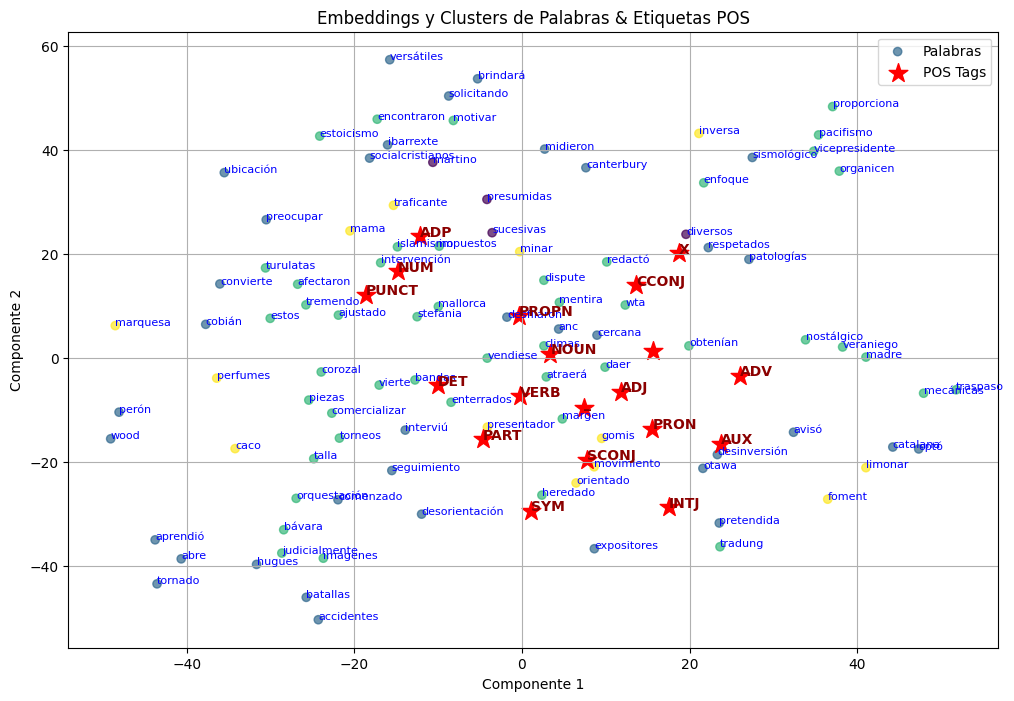

In [15]:
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap="viridis", label="Palabras", alpha=0.7)
plt.scatter(pos_embeds_2d[:, 0], pos_embeds_2d[:, 1], marker="*", s=200, c="red", label="POS Tags")

for i, w in enumerate(random_words):
    plt.annotate(w, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, color="blue")

for i, p in enumerate(pos_tags):
    plt.annotate(p, (pos_embeds_2d[i, 0], pos_embeds_2d[i, 1]), fontsize=10, weight="bold", color="darkred")

plt.legend()
plt.title("Embeddings y Clusters de Palabras & Etiquetas POS")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()

In [16]:
print("""
Conclusiones:
La agrupación de palabras muestra cierta coherencia semántica basada en sus embeddings.
Las etiquetas POS ocupan regiones distintas en el espacio 2D, indicando la separación de roles gramaticales.
Los embeddings estáticos permiten visualizar relaciones globales entre palabras, mientras que los embeddings de etiquetas ayudan a ver la estructura gramatical.
""")


Conclusiones:
La agrupación de palabras muestra cierta coherencia semántica basada en sus embeddings.
Las etiquetas POS ocupan regiones distintas en el espacio 2D, indicando la separación de roles gramaticales.
Los embeddings estáticos permiten visualizar relaciones globales entre palabras, mientras que los embeddings de etiquetas ayudan a ver la estructura gramatical.

